In [2]:
# Step 1: Import preprocessing function
from preprocess import clean_mental_health_data

# Step 2: Clean the data
df, label_dict = clean_mental_health_data("Data/survey.csv")

In [3]:
df

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.186275,0,0,0,1,1,4,0,1,2,...,2,1,1,1,2,1,0,2,0,31-65
1,0.254902,1,0,0,0,2,5,0,0,0,...,0,0,1,0,0,1,1,0,0,31-65
2,0.137255,1,0,0,0,2,4,0,1,1,...,1,1,1,2,2,2,2,1,0,31-65
3,0.127451,1,0,1,1,1,2,0,1,1,...,1,2,2,1,0,0,0,1,1,31-65
4,0.127451,1,0,0,0,0,1,1,1,2,...,0,1,1,1,2,2,2,0,0,31-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.078431,1,0,0,1,4,2,0,1,1,...,2,1,1,1,1,1,1,0,0,21-30
1255,0.137255,1,0,1,1,1,2,1,1,2,...,1,1,1,1,2,1,1,2,0,31-65
1256,0.156863,1,0,1,1,3,5,0,1,2,...,1,2,2,0,0,1,1,1,0,31-65
1257,0.274510,0,0,0,0,4,1,1,1,1,...,0,2,1,0,0,1,1,1,0,31-65


In [4]:
from sklearn.model_selection import train_test_split

# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = df[feature_cols]
y = df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

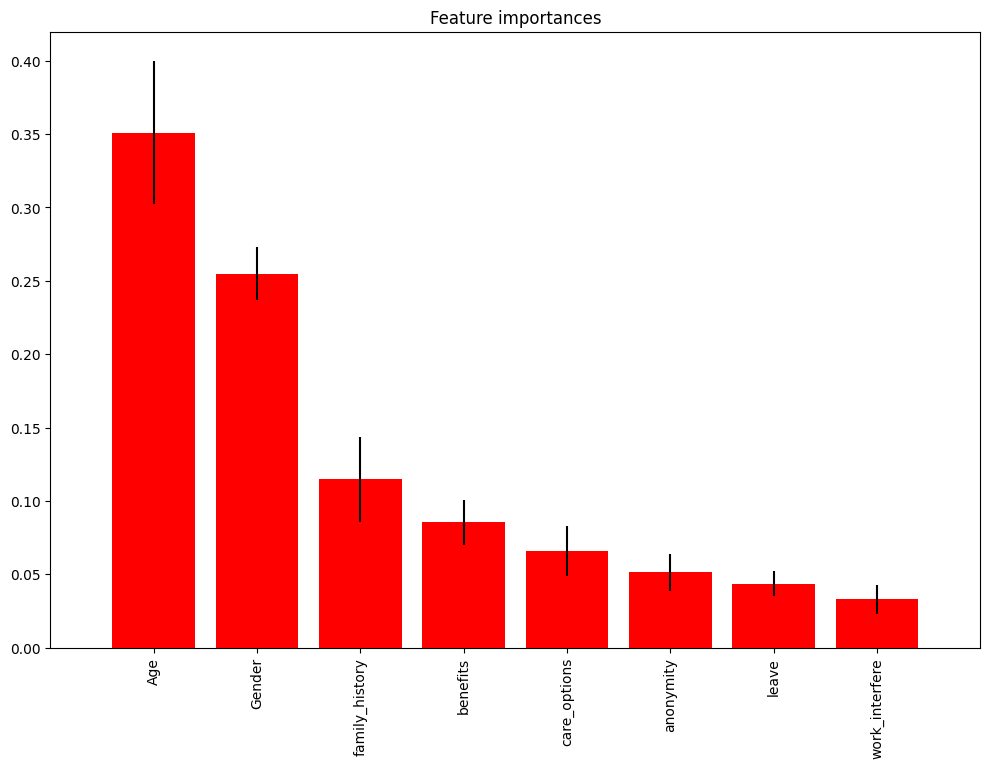

In [5]:
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import binarize
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def evalClassModel(model, y_test, y_pred_class, plot=False):
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))

    # Null accuracy
    print('Null accuracy:\n', y_test.value_counts())
    print('Percentage of ones:', y_test.mean())
    print('Percentage of zeros:', 1 - y_test.mean())

    # Compare predictions
    print('True :', y_test.values[0:25])
    print('Pred :', y_pred_class[0:25])

    # Confusion Matrix
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    TP, TN, FP, FN = confusion[1, 1], confusion[0, 0], confusion[0, 1], confusion[1, 0]

    sns.heatmap(confusion, annot=True, fmt="d")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Metrics from confusion matrix
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    print('Classification Error:', 1 - accuracy)
    print('False Positive Rate:', FP / float(TN + FP))
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))

    # Cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())

    # Probabilities
    print('First 10 predicted responses:', model.predict(X_test)[0:10])
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])
    print('First 10 probabilities for class 1:', model.predict_proba(X_test)[0:10, 1])

    # Store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    if plot:
        plt.rcParams['font.size'] = 12
        plt.hist(y_pred_prob, bins=8)
        plt.xlim(0, 1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of class 1')
        plt.ylabel('Frequency')
        plt.show()

    # Apply custom threshold
    y_pred_class = binarize(y_pred_prob.reshape(-1, 1), threshold=0.3).flatten()
    print('First 10 predicted class values with threshold=0.3:\n', y_pred_class[0:10])

    # ROC Curve and AUC
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

    if plot:
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

    # Evaluate a custom threshold = 0.5 (example)
    predict_mine = np.where(y_pred_prob > 0.5, 1, 0)
    confusion_custom = metrics.confusion_matrix(y_test, predict_mine)
    print('Confusion matrix with threshold=0.5:\n', confusion_custom)

    return accuracy


In [7]:
from sklearn.neighbors import KNeighborsClassifier

##########################################
# Tuning with cross validation score
##########################################
def tuningCV(knn):
    
    # search for an optimal value of K for KNN
    k_range = list(range(1, 31))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())
    print(k_scores)
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()

In [8]:
from sklearn.model_selection import GridSearchCV

def tuningGridSerach(knn):
    #More efficient parameter tuning using GridSearchCV
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    print(k_range)
    
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)
    
    # instantiate the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

    # fit the grid with data
    grid.fit(X, y)
    
    # view the complete results (list of named tuples)
    grid.grid_scores_
    
    # examine the first tuple
    print(grid.grid_scores_[0].parameters)
    print(grid.grid_scores_[0].cv_validation_scores)
    print(grid.grid_scores_[0].mean_validation_score)
    
    # create a list of the mean scores only
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    print(grid_mean_scores)
    
    # plot the results
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
    # examine the best model
    print('GridSearch best score', grid.best_score_)
    print('GridSearch best params', grid.best_params_)
    print('GridSearch best estimator', grid.best_estimator_)

In [9]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV

def tuningRandomizedSearchCV(model, param_dist):
    print("### RandomizedSearchCV (1 run + 20 repetitions) ###")

    # Première recherche pour afficher les meilleurs paramètres
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)

    print('Rand. Best Score:', rand.best_score_)
    print('Rand. Best Params:', rand.best_params_)

    # Affichage des 10 meilleures combinaisons (facultatif mais utile)
    results = pd.DataFrame(rand.cv_results_)
    top10 = results[['mean_test_score', 'params']].sort_values(by='mean_test_score', ascending=False).head(10)
    print('\nTop 10 parameter combinations:')
    print(top10.to_string(index=False))

    # Répéter 20 fois pour voir la variabilité des meilleurs scores
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))

    print('\n20 best scores (for variability check):')
    print(best_scores)


In [10]:
def tuningMultParam(knn):
    
    #Searching multiple parameters simultaneously
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
        
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range, weights=weight_options)
    print(param_grid) 
    
    # instantiate and fit the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y) 
    
    # view the complete results
    print(grid.grid_scores_)
    
    # examine the best model
    print('Multiparam. Best Score: ', grid.best_score_)
    print('Multiparam. Best Params: ', grid.best_params_)

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

def boosting():
    # Construire et entraîner le modèle de boosting
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    boost = AdaBoostClassifier(estimator=clf, n_estimators=500, random_state=42)
    boost.fit(X_train, y_train)
    
    # Prédictions sur le set test
    y_pred_class = boost.predict(X_test)
    
    print('########### Boosting ###############')
    
    accuracy_score = evalClassModel(boost, y_test, y_pred_class, True)

    # Stocker la performance pour la visualisation finale
    methodDict['Boosting'] = accuracy_score * 100


########### Boosting ###############
Accuracy: 0.8148148148148148
Null accuracy:
 treatment
1    190
0    188
Name: count, dtype: int64
Percentage of ones: 0.5026455026455027
Percentage of zeros: 0.4973544973544973
True : [0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0]
Pred : [1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0]


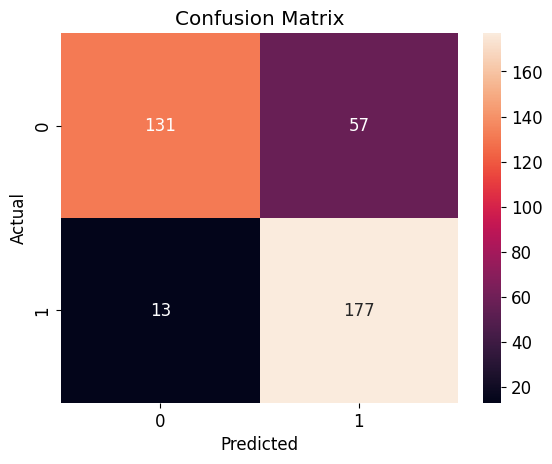

Classification Accuracy: 0.8148148148148148
Classification Error: 0.18518518518518523
False Positive Rate: 0.30319148936170215
Precision: 0.7564102564102564
AUC Score: 0.8141937290033594
Cross-validated AUC: 0.89643560679947
First 10 predicted responses: [1 0 0 1 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[0.43664148 0.56335852]
 [0.70858341 0.29141659]
 [0.70858736 0.29141264]
 [0.40825949 0.59174051]
 [0.49372927 0.50627073]
 [0.39840267 0.60159733]
 [0.57474879 0.42525121]
 [0.46992138 0.53007862]
 [0.32120282 0.67879718]
 [0.42278714 0.57721286]]
First 10 probabilities for class 1: [0.56335852 0.29141659 0.29141264 0.59174051 0.50627073 0.60159733
 0.42525121 0.53007862 0.67879718 0.57721286]


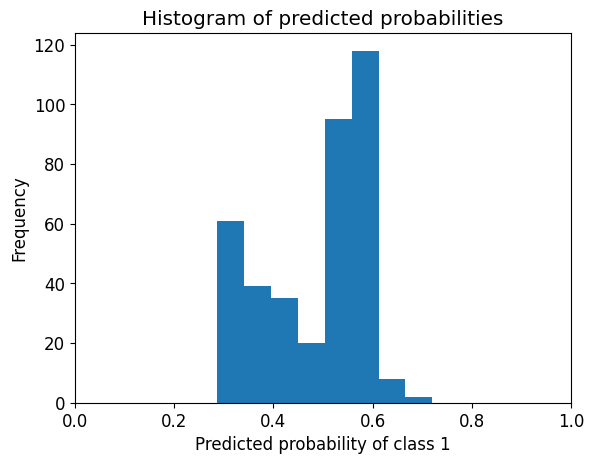

First 10 predicted class values with threshold=0.3:
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]


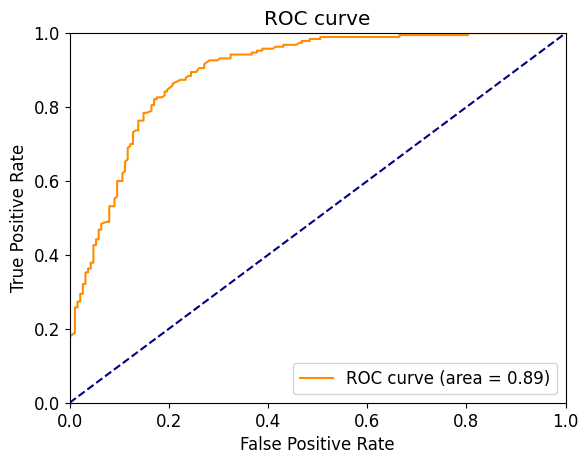

Confusion matrix with threshold=0.5:
 [[131  57]
 [ 13 177]]


In [22]:
boosting()